In [1]:
%matplotlib inline

import os
import random
import fnmatch
import datetime
import pickle
import sys
import glob
import math
import h5py
import numpy as np

import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

Using TensorFlow backend.
tf.__version__: 2.1.0
keras.__version__: 2.3.1


In [2]:
model_output_dir = './nvidia_model'
datasetDirTrain = '/media/zx/eff30071-6ef0-4269-8d39-989b25203d99/gft_deep_workspace/dataset/'
datasetFilesTrain = glob.glob(datasetDirTrain+'*.h5')

<HDF5 file "carla-dataset-2021-03-21.h5" (mode r)>
KeysView(<HDF5 file "carla-dataset-2021-03-21.h5" (mode r)>)
(1156, 160, 384, 3)
(1156,)
1156


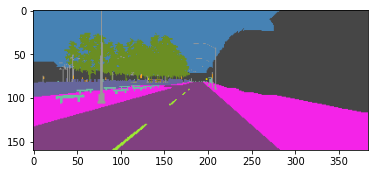

In [3]:
dataset = h5py.File(datasetFilesTrain[0], 'r')

print(dataset)
print(dataset.keys())
print(dataset['rgb'].shape)
print(dataset['measurements'].shape)

ind = 2
x = dataset['rgb'][ind]
size_dataset = len(dataset['rgb']) 
plt.imshow(x)
dataset.close()
print(size_dataset)

In [4]:
images = []
steering_angles = []
batch_data_siz = 1

for idData in range(0,batch_data_siz):
    try:
        dataset = h5py.File(datasetFilesTrain[idData], 'r')
        for idx in range(0,size_dataset):
            steering_angles.append(math.degrees(math.acos(dataset['measurements'][idx][0])))
            images.append(dataset['rgb'][idx])
        dataset.close()
    except: 
        print(datasetFilesTrain[idData])

df = pd.DataFrame()
df['ImagePath'] = images
df['Angle'] = steering_angles

(array([6.0000, 5.0000, 6.0000, 5.0000, 6.0000, 3.0000, 11.0000, 11.0000,
        3.0000, 10.0000, 7.0000, 53.0000, 800.0000, 44.0000, 24.0000,
        7.0000, 50.0000, 45.0000, 12.0000, 15.0000, 10.0000, 7.0000,
        7.0000, 6.0000, 3.0000]),
 array([64.1320, 66.2321, 68.3322, 70.4323, 72.5324, 74.6325, 76.7326,
        78.8327, 80.9328, 83.0329, 85.1330, 87.2331, 89.3333, 91.4334,
        93.5335, 95.6336, 97.7337, 99.8338, 101.9339, 104.0340, 106.1341,
        108.2342, 110.3343, 112.4344, 114.5346, 116.6347]),
 <BarContainer object of 25 artists>)

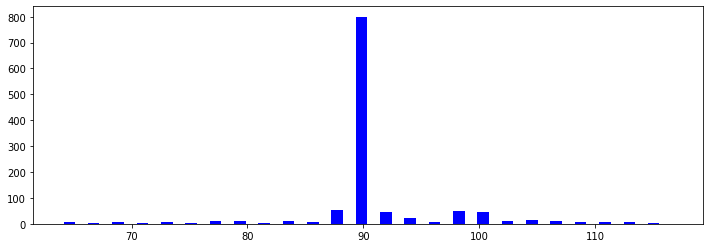

In [5]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 924
Validation data: 232


Text(0.5, 1.0, 'Validation Data')

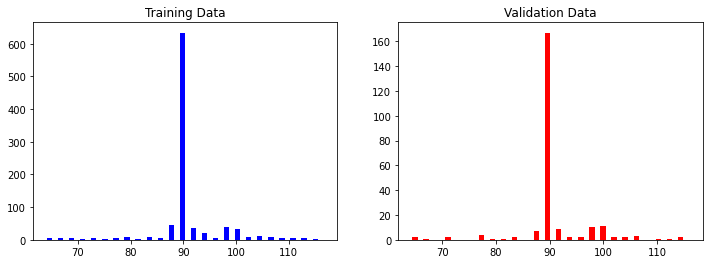

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split( images, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

In [7]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

def random_flip(image, steering_angle):
    #is_flip = random.randint(0, 1)
    #if is_flip == 1:
        # randomly flip horizon
    #    image = cv2.flip(image,1)
    #    steering_angle = -1 * steering_angle
   
    return image, steering_angle

def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle

Text(0.5, 1.0, 'processed')

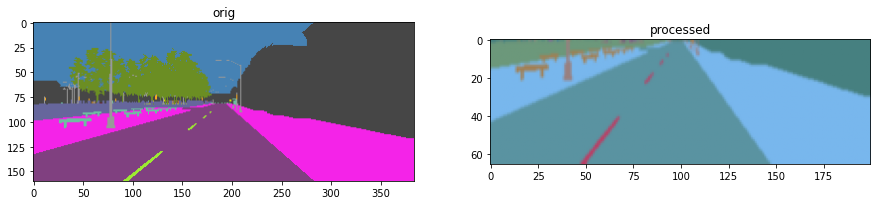

In [8]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66))
    image = image / 255 
    return image

image_index = 2
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = images[image_index]
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [9]:
def image_data_generator(images, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(images) - 1)
            image = images[random_index]
            steering_angle = steering_angles[random_index]
            if is_training:
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

In [10]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers 160, 384    66,200
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [11]:
model = nvidia_model()
#plot_model(model,to_file='nvidia.png',show_shapes=True)
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

In [12]:
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root

In [13]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=924, is_training=True),
                              steps_per_epoch=30,
                              epochs=20,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=232, is_training=False),
                              validation_steps=20,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 30 steps, validate for 20 steps
Epoch 1/20
29/30 [============================>.] - ETA: 1s - loss: 1533.9795 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 90.55766, saving model to ./nvidia_model/lane_navigation_check.h5
30/30 [==============================] - 62s 2s/step - loss: 1486.0856 - accuracy: 0.0000e+00 - val_loss: 90.5577 - val_accuracy: 0.0000e+00
Epoch 2/20
29/30 [============================>.] - ETA: 1s - loss: 58.2388 - accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 90.55766 to 36.43882, saving model to ./nvidia_model/lane_navigation_check.h5
30/30 [==============================] - 62s 2s/step - loss: 57.9580 - accuracy: 0.0000e+00 - val_loss: 36.4388 - val_accuracy: 0.0000e+00
Epoch 3/20
29/30 [============================>.] - ETA: 1s - loss: 47.0089 - accuracy: 0.0000e+00
Epoch 00003: val_loss improved

In [14]:
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

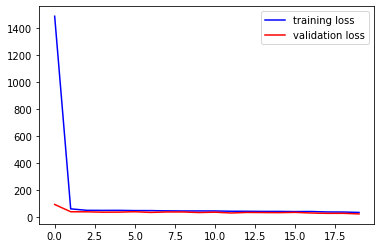

In [15]:
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

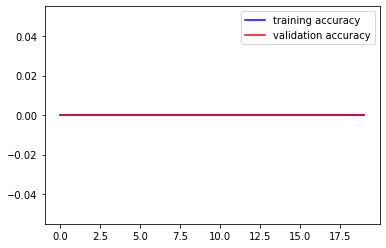

In [16]:
plt.plot(history['accuracy'],color='blue')
plt.plot(history['val_accuracy'],color='red')
plt.legend(["training accuracy", "validation accuracy"])

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_final.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

mse       = 3.1e+01
r_squared = 31.32%



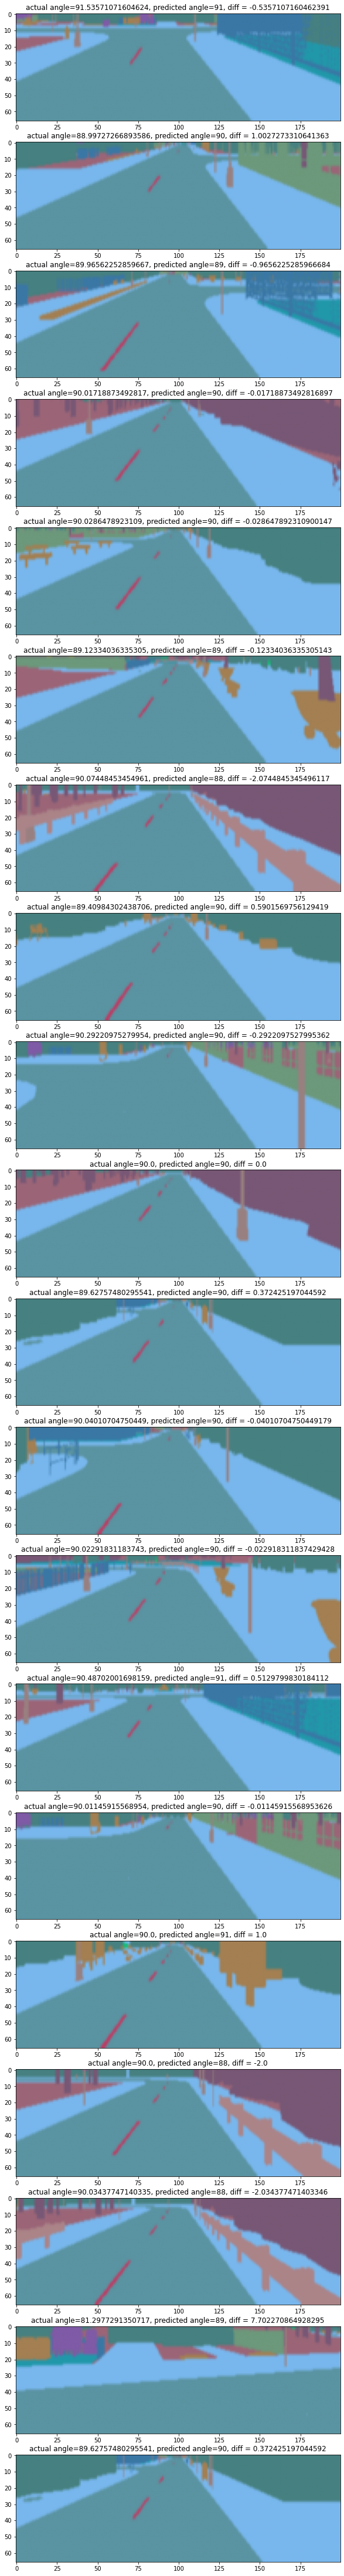

In [18]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 20
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")